# Convolutional Neural Networks
![](images/cnn.png)

* Today we will see convolutional neural networks (CNNs), a type of neural network which is specifically well suited for dealing with images. In the previous tutorial we have seen that multilayer perceptrons present strong limitations when dealing with high dimensional inputs and in this tutorial we will see how CNNs are able to overcome these limitations

* The goal of this notebook is to make you get familiar with CNNs and keep making you get familiar with PyTorch autodifferentiation properties.


* We will be training a CNN on the Hymenoptera dataset which you can download from 
[here](https://download.pytorch.org/tutorial/hymenoptera_data.zip).


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import time
import os
import copy
from matplotlib import pyplot as plt 

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 1. Load the dataset

* As we have seen last week we will have to load the dataset in a similar fashion by making use of PyTorch's dataloaders. To keep things as simple as possible for now we would like the data to have the same dimensionality as the one we have loaded last week when dealing with the CIFAR-10 dataset.

### Visualize the data

If the dataset is loaded properly you should be able to see some random images of bees and ants, which are the two classes we will be classifying today.

In [16]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

trainloader = dataloaders['train']
valloader = dataloaders['val']

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

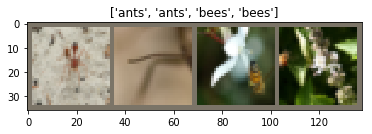

In [17]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Computation Graph

You are free to define any kind of convolutional neural network hat you think is reasonable for today's problem.
Remember that convolutional neural networks are usually a combination of the following building blocks:

  * Convolutional layers
  * Pooling layers
  * Linear layers
  
It is your task today to arrange these components into a reasonable architecture.

In [18]:
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self, output_dim):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1), #in_channels, out_channels, kernel_size, stride, padding
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), #kernel_size
            nn.Conv2d(64, 192, 3, padding = 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(192, 384, 3, padding = 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding = 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

### Training Set-up

Just like last week once your computation graph is defined you will have to define your experimental set-up: this includes the construction of the network, the definition of an objective function to minimize and an optimization algorithm.

In [19]:
net = ConvNet(2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train the network

Once everything is ready you will have to train the network and measure its performance.
Discuss the performance of your model

In [20]:
def calculate_accuracy(x, y):
    preds = x.argmax(1, keepdim=True)
    correct = preds.eq(y.view_as(preds)).sum()
    acc = correct.float()/preds.shape[0]
    return acc

In [21]:
def train(model, optimizer):
    model.train()

    for epoch in range(3):
        training_loss = 0
        training_acc = 0
        
        validation_loss = 0
        validation_acc = 0
        
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            acc = calculate_accuracy(outputs, labels)
            
            loss.backward()
            optimizer.step()

            training_loss += loss.item()
            training_acc += acc.item()
            
            with torch.no_grad():
                for i, data in enumerate(valloader, 0):
                    val_inputs, val_labels = data
                    
                    outputs = model(val_inputs)
                    
                    acc = calculate_accuracy(outputs, val_labels)
                    validation_acc += acc.item()

        print(training_loss / len(trainloader), training_acc / len(trainloader))
        print(validation_loss / len(valloader), validation_acc / len(valloader))
            
    print('Finished Training')

In [ ]:
train(net, optimizer)

(0.694684446835127, 0.430327868852459)
(0, 29.807692307692307)
(0.6945546894777016, 0.39344262295081966)
(0, 31.576923076923077)


### Use a pre-trained model

You might have noticed that training a CNN from scratch can be very slow and that the overall performance might not be satisfying. To overcome this we can use a pre-trained network and fine-tune it on our Hymenoptera dataset.

You are free to choose any pre-trained model that the PyTorch library offers evaluate and compare its performance to the CNN you have built yourself.

In [12]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

train(model_ft, optimizer_ft)

(0.5604771497796793, 0.7131147540983607)
(0, 43.5)


Process Process-257:
Process Process-259:
Process Process-264:
Process Process-262:
Traceback (most recent call last):
Process Process-258:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/matthia/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Process Process-261:
Process Process-260:
Process Process-263:
Traceback (most recent call last):
  File "/home/matthia/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/matthia/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/matthia/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/matthia/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
    self.run()
    self.run()
  File "/home/matthia/anaconda2/lib/python2.7/m

KeyboardInterrupt: 